# Paper replication

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [2]:
from utils import all_combinations

M = 2
D = 3 * 3
ALL_INPUTS = all_combinations(M, D)

## Define CAs and training data

In [3]:
from ca_funcs import make_table_walk, make_ca

def sample_CAs(seed=None):
    if seed:
        np.random.seed(seed)

    inputs = ALL_INPUTS
    outputs = make_table_walk(len(ALL_INPUTS))
    for o in outputs:
        yield make_ca(inputs, o)

def generate_CA_train_data(ca, height=10, width=10, n_samples=500):
    X_train = torch.from_numpy(np.random.choice([0, 1], (n_samples, height, width), p=[.5, .5])).float()
    Y_train = ca(X_train).float()
    return X_train, Y_train

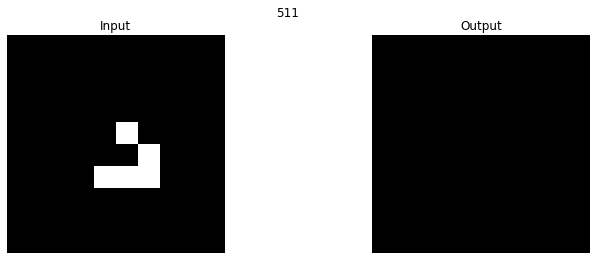

In [4]:
from ca_funcs import make_glider
from IPython.display import clear_output

np.random.seed(0)

for i, ca in enumerate(sample_CAs()):
    X_test = torch.from_numpy(make_glider(10).reshape(1, 10, 10)).float()
    Y_test = ca(X_test).float()

    plt.figure(figsize=(12,4))
    plt.suptitle(i)

    plt.subplot(1,2,1)
    plt.imshow(X_test[0])
    plt.axis('off')
    plt.title("Input")

    plt.subplot(1,2,2)
    plt.imshow(Y_test[0])
    plt.axis('off')
    plt.title("Output")

    plt.show()
    plt.close()
    clear_output(wait=True)

## Find entropy of the training CA

In [5]:
from collections import Counter
from utils import shannon_entropy

def ca_entropy(ca):
    inputs = torch.from_numpy(ALL_INPUTS)
    outputs = ca(inputs)
    output_counts = np.array(list(Counter(tuple(torch.reshape(o, [-1]).numpy()) for o in outputs).values()))
    output_ps = output_counts / len(inputs)
    return shannon_entropy(output_ps)

512it [00:07, 64.91it/s]


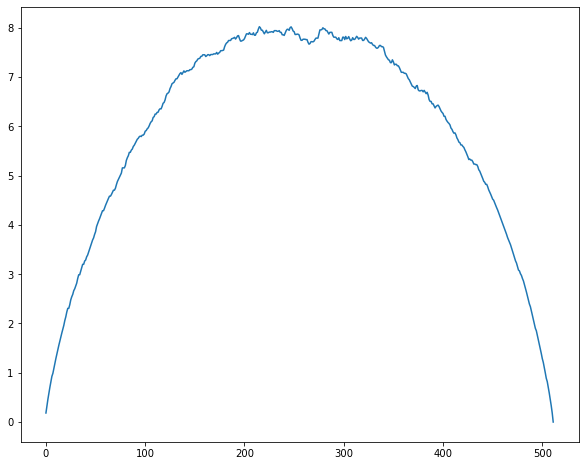

In [6]:
entropies = [ca_entropy(a) for a in tqdm(sample_CAs(seed=0))]
plt.plot(entropies)

## Define the model

In [7]:
from train_ca import initialize_model

seed = 0
print('seed =', seed)

np.random.seed(seed)
torch.random.manual_seed(seed)

num_classes = 2
samples = 500
input_dims = [10, 10]
layer_dims = [100] + [100] * 11  # neighborhood conv + mlpconv layers
batch_size = 10
num_batches = samples / batch_size
learning_rate = 1e-4
training_epochs = 150  # 1500
display_step = int(training_epochs / 10)
loss = torch.nn.MSELoss()

model = initialize_model(input_dims, layer_dims)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

if torch.cuda.is_available():
    model.cuda()

seed = 0
Sequential(
  (Wraparound2D): Wraparound2D()
  (Conv2d_0): Conv2d(1, 100, kernel_size=(3, 3), stride=(1, 1))
  (Conv2d_1): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  (Conv2d_2): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  (Conv2d_3): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  (Conv2d_4): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  (Conv2d_5): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  (Conv2d_6): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  (Conv2d_7): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  (Conv2d_8): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  (Conv2d_9): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  (Conv2d_10): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  (Conv2d_11): Conv2d(100, 100, kernel_size=(1, 1), stride=(1, 1))
  (Conv2d_12): Conv2d(100, 1, kernel_size=(1, 1), stride=(1, 1))
  (Lambda_0): Lambda()
)


## Define the learning loop

In [8]:
losses = []

def learn_CA(ca, model):
    for _ in tqdm(range(training_epochs)):
        X_train, Y_train = generate_CA_train_data(ca, *input_dims, n_samples=samples)

        if torch.cuda.is_available():
            X_train = X_train.cuda()
            Y_train = Y_train.cuda()

        optimizer.zero_grad()
        Y_pred = model(X_train)
        l = loss(Y_train, Y_pred)
        l.backward()
        optimizer.step()
        losses.append(l.item())

## Train the model

In [9]:
ca = list(sample_CAs(seed=0))[250]
learn_CA(ca, model)

100%|██████████| 150/150 [00:21<00:00,  7.12it/s]


[]

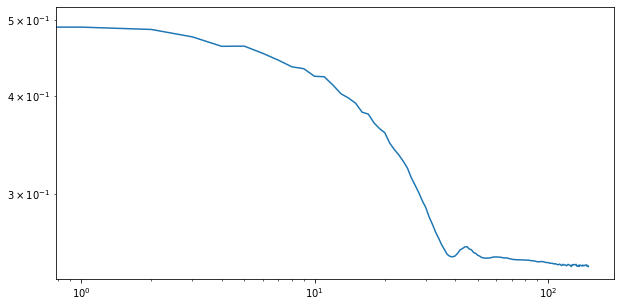

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(losses)
plt.loglog()

Text(0.5, 1.0, 'Diff')

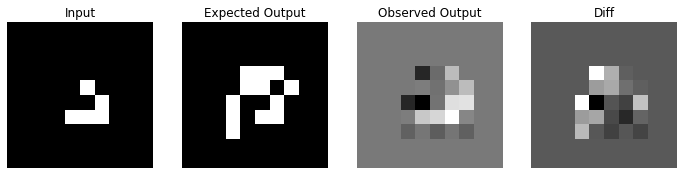

In [11]:
from ca_funcs import make_glider

# x = np.random.choice([0, 1], size=100)
x = make_glider(10)
X_test = torch.from_numpy(x.reshape(1, 10, 10)).float()
Y_test = ca(X_test).float()

if torch.cuda.is_available():
    X_test = X_test.cuda()
Y_pred = model(X_test)


if torch.cuda.is_available():
    X_test = X_test.cpu()
    Y_pred = Y_pred.cpu()

X_test = X_test.detach().numpy()
Y_test = Y_test.detach().numpy()
Y_pred = Y_pred.detach().numpy()

plt.figure(figsize=(12, 4))

plt.subplot(141)
plt.imshow(X_test[0])
plt.axis('off')
plt.title("Input")

plt.subplot(142)
plt.imshow(Y_test[0])
plt.axis('off')
plt.title("Expected Output")

plt.subplot(143)
plt.imshow(Y_pred[0])
plt.axis('off')
plt.title("Observed Output")

plt.subplot(144)
plt.imshow((Y_pred[0] - Y_test[0]) ** 2)
plt.axis('off')
plt.title("Diff")

In [12]:
np.max(np.abs(Y_pred[0] - Y_test[0]))

0.6432269

## Find model entropies

In [13]:
from ca_funcs import get_network_entropies


def get_activations(x_input):
    activations = [x_input]
    for m in model.modules():
        x_input = m(x_input)
        activations.append(x_input)
    return activations[3:len(activations) - 2]


X_test = torch.from_numpy(np.random.choice([0, 1], (500, 10, 10))).float()
if torch.cuda.is_available():
    X_test = X_test.cuda()

layer_activations = np.array([activation.cpu().detach().numpy() for activation in get_activations(X_test)])
binary_activations = np.digitize(layer_activations, [0], right=True)
entropies = get_network_entropies(binary_activations)

In [14]:
ca_entropy(ca)

8.220523247971135

In [15]:
entropies

(9.162932399820573,
 [1.8489180377637644,
  2.0220420738754203,
  1.9059219471764053,
  2.2634319969878147,
  1.5387841046039683,
  1.4632430463958275,
  1.0979005219867841,
  1.1114348455610503,
  1.0659691896822747,
  0.7812409149025803,
  0.9867476499790482,
  1.034374078411619],
 [array([0.69272905, 0.69271022, 0.69271881, 0.69272523, 0.69271881,
         0.69274894, 0.69273194, 0.69271529, 0.69272917, 0.6927418 ]),
  array([0.67806586, 0.67813577, 0.67815951, 0.67812669, 0.67808545,
         0.67818253, 0.67807076, 0.67819926, 0.67808125, 0.67811132]),
  array([0.6914085 , 0.69140047, 0.69140661, 0.69140827, 0.69140189,
         0.69138624, 0.69139692, 0.69139881, 0.69144374, 0.69140236]),
  array([0.69251678, 0.69250465, 0.69252189, 0.69250909, 0.69251194,
         0.69252781, 0.69249066, 0.69251778, 0.69249514, 0.69252273]),
  array([0.68519412, 0.68524166, 0.68520678, 0.68522751, 0.68525176,
         0.68523156, 0.68522297, 0.68525781, 0.68523509, 0.68525731]),
  array([0.69304